## Requirements:

Hierarchy transformers is not a standard library, in order to run this notebook, please:

git clone https://github.com/CEBangu/HierarchyTransformers.git OR the original: https://github.com/KRR-Oxford/HierarchyTransformers.git

NB! original will run into problems when running the eval scrip on Mac, ours will not. 

pip install hierarchytransformers

pip install -e



In [ ]:
from hierarchy_transformers import HierarchyTransformer
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
import torch.nn.functional as F
import torch 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import umap

by Ciprian Bangu & Daniel Dager

# Notebook 1: Paper result reproduction and exploration.

The practical portion of our project is an extension of the work done in "Language Models as Hierarchy Encoders" by He et al. (Neurips, 2024). For more information about the paper, and the theoretical background of the Hyperbolic Neural Networks, please see our poster. 

 In this notebook, we

1. Show our reproduction of the evaluation results on MixedHop Negatives (the code to run the simulation is included, but one needs to clone the repo in order to perserve the file structure)
2. Visualize the final embeddings of the Hierarchy Transformer and subsumption scores to gain insights into the working of the model. 
3. Apply the same visualizations measures to the non-finetuned version of the base model, all-MiniLM-L12-v2 (Nils et al. 2021). 
4. Apply the same visualizations and measures to a version of all-MiniLM-L12-v2 fine-tuned on the MixedHop Negatives dataset. 
5. Apply measures to assess the hyperbolicity of the word embeddings, and compare the embeddings between the models. 

Training and Fine-tuning scripts are provided by He et al. 

# Part 1: Re-evaluating and investigating the Hierarchy Transformer (HiT)

## Evaluation Commands
NB! This takes about an 45 mins

This notebook is be submitted with the tsv, but if you want to generate the results, run the evaluation script

In [ ]:
import os
cwd = os.getcwd()
output_path = cwd + "/scripts/evaluation/hit/hit_eval_local"
if not os.path.exists(output_path):
  os.makedirs(output_path)

eval_path = cwd + "/scripts/evaluation/hit"
config_file = eval_path + "/config_hit.yaml"

!python {eval_path}/eval_hit.py --config_file {config_file} --output_path {output_path}

## Results

In [107]:
evaluation_path = os.getcwd() + '/scripts/evaluation/hit/hit_eval_local/' # NB! set own path
evaluation_results = pd.read_csv(evaluation_path + "results.tsv", sep='\t')
evaluation_results

,Unnamed: 0,centri_weight,threshold,precision,recall,f1,accuracy,accuracy_on_negatives
0,validation,2.0,-13.04,0.877274,0.895494,0.886290,0.979111,0.987472
1,testing,2.0,-13.04,0.876915,0.893568,0.885163,0.978922,0.987458


## Looking at the model's embeddings

In [108]:
# load the model
hierarcy_transformer = HierarchyTransformer.from_pretrained('Hierarchy-Transformers/HiT-MiniLM-L12-WordNetNoun')
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
hierarcy_transformer.to(device=device)

HierarchyTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [ ]:
# Get the dataset that the model was trained on
pairs_dataset = load_dataset("Hierarchy-Transformers/WordNetNoun", "MixedHop-RandomNegatives-Pairs")

In [110]:
# First, encode all of the available entities. 
entity_names = list(set(pairs_dataset['train']['child'] + pairs_dataset['train']['parent']))
entity_embeddings = hierarcy_transformer.encode(entity_names) # 38 seconds

### Visualizing with UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/hierarchytransformers/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/hierarchytransformers/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


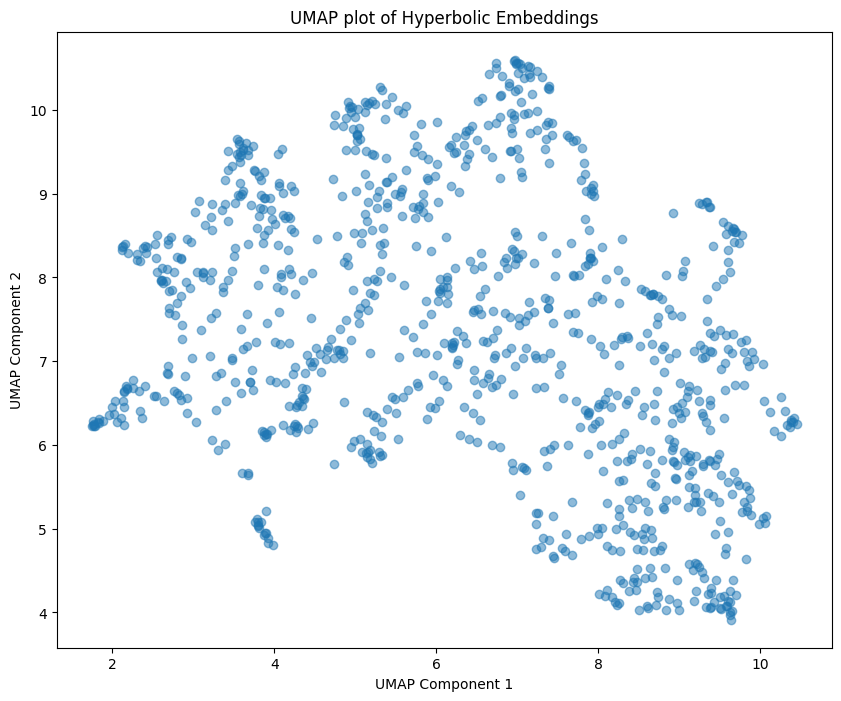

In [260]:
# acutally Umaping on 60k pairs takes forever, here we take a subset of 1k to show embeddings
np.random.seed(42)
hyperbolic_embeddings = entity_embeddings[np.random.choice(len(entity_embeddings), size=1000, replace=False)]

# Perform UMAP on the entity embeddings
umap_model = umap.UMAP(n_components=2, random_state=42)
entity_embeddings_2d = umap_model.fit_transform(hyperbolic_embeddings)

# Plot the UMAP results in 2D
plt.figure(figsize=(10, 8))
plt.scatter(entity_embeddings_2d[:, 0], entity_embeddings_2d[:, 1], marker='o', alpha=0.5)
plt.title('UMAP plot of Hyperbolic Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()


Unforutnately, UMAP distorts the actual embedding space since it is not made to handle hyperbolic embeddings. Acutally, there is not really a standard way of visualizing hyperbolic embeddings. However, we do see that distinct clusters do form, indicating that the Hierarchy Transformer's embeddings do form clusters in terms of hierarchy. However, there is a lack of directionality in the UMAP space which makes teasing out the exact relationships difficult

### Now, we will look at only the proper pairs - i.e., the model's representations of the relationships of true positives.

In [191]:
# Subset the dataset to include only rows where the 'label' column has the value 1 (i.e., where there is an actual child-parent relationship)
proper_pairs = pairs_dataset['train'].filter(lambda data: data['label'] == 1)
proper_pairs_subset = proper_pairs.shuffle(seed=42).select(range(1000))

In [195]:
# Get the embeddings for the subset
child_entity_embeddings = hierarcy_transformer.encode(proper_pairs_subset['child'], convert_to_tensor=True)
parent_entity_embeddings = hierarcy_transformer.encode(proper_pairs_subset['parent'], convert_to_tensor=True)

In hyperbolic space, the magnitude of the norm indicates an embedding's depth within the global hierarchy. If an embedding's norm is high, then it lies closer to the boundary, indicating that it is a specialized concept. Conversely, if an embedding's norm is low, it means that it is closer to the center, indicating a more general concept. An example of this relationship would be that of "Rose" to "Flower": we would expect the norm of Flower to be lower than that of Rose, since Flower is the more general concept.

Below, we look at the distributions of the norms in the Child & Parent classes:

In [ ]:
# compute the hyperbolic norms of entity embeddings
child_norms = hierarcy_transformer.manifold.dist0(child_entity_embeddings)
parent_norms = hierarcy_transformer.manifold.dist0(parent_entity_embeddings)

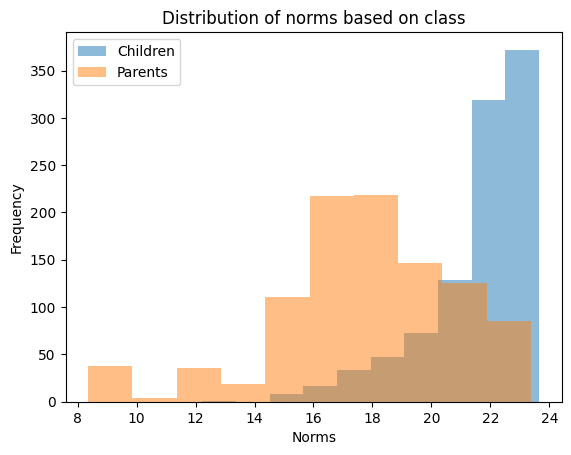

In [305]:
child_norms, parent_norms = child_norms.cpu().numpy(), parent_norms.cpu().numpy()
fig, ax = plt.subplots()
ax.hist(child_norms, label="Children", alpha=0.5)
ax.hist(parent_norms, label="Parents", alpha=0.5)
ax.set_xlabel("Norms")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of norms based on class")
ax.legend()
plt.show()

From the plot above, we can see that this relationship between the class and the norms has been verified. That is, children norms cluster on the high end, while parent norms tend to be significanlty lower.

In their paper, He et al. define the 'subsumption score' to assess the distances between points in hyperbolic space:

$$
s(e_1 \sqsubseteq e_2) = -\left( d_c(e_1, e_2) + \lambda \left( \| e_2 \|_c - \| e_1 \|_c \right) \right)
$$

where $e_1$ and $e_2$ are the entities, $d_c(\cdot, \cdot)$ is the hyperbolic distance metric, and $\lambda$ is a weighting factor determined via the validation set. This score *increases* as the distance between points *decreseases*

We can look at the subsumption scores in between true pairs and false pairs.

In [199]:
# use the empirical function for subsumption prediction proposed in the paper
centri_score_weight = evaluation_results.iloc[0, 1] # use the result on the validation set
threshold = evaluation_results.iloc[0, 2]

In [236]:
# getting the embeddings for the non-proper pairs
bad_pairs = pairs_dataset['train'].filter(lambda data: data["label"] == 0)
bad_pairs_subset = bad_pairs.shuffle(seed=42).select(range(1000))

In [ ]:
# embed the children an parents
bad_child_entity_embeddings = hierarcy_transformer.encode(bad_pairs_subset['child'], convert_to_tensor=True)
bad_parent_entity_embeddings = hierarcy_transformer.encode(bad_pairs_subset['parent'], convert_to_tensor=True)

# get the distances for the proper pairs
good_dists = hierarcy_transformer.manifold.dist(child_entity_embeddings, parent_entity_embeddings)
bad_dists = hierarcy_transformer.manifold.dist(bad_child_entity_embeddings, bad_parent_entity_embeddings)

# get the distances for the improper pairs
bad_child_norms = hierarcy_transformer.manifold.dist0(bad_child_entity_embeddings)
bad_parent_norms = hierarcy_transformer.manifold.dist0(bad_parent_entity_embeddings)

# get the subsumption scores
good_subsumption_scores = - (good_dists.cpu() + centri_score_weight * (parent_norms - child_norms))
bad_subsumption_scores = - (bad_dists.cpu() + centri_score_weight * (bad_parent_norms.cpu() - bad_child_norms.cpu()))

/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_52804/3583951040.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  good_subsumption_scores = - (good_dists.cpu() + centri_score_weight * (parent_norms - child_norms))


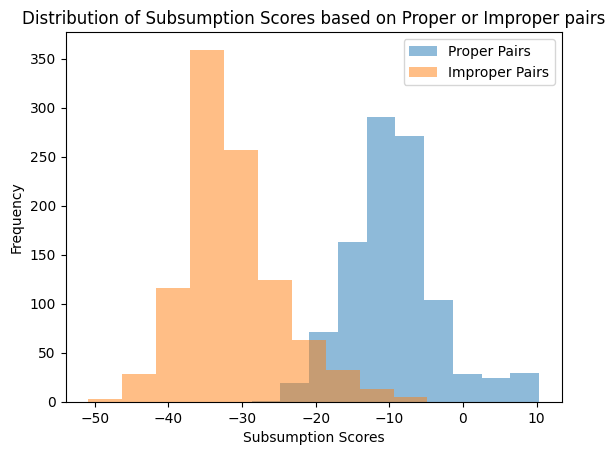

In [244]:
fig, ax = plt.subplots()
ax.hist(good_subsumption_scores, alpha=0.5, label="Proper Pairs")
ax.hist(bad_subsumption_scores, alpha=0.5, label="Improper Pairs")
ax.set_xlabel("Subsumption Scores")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Subsumption Scores based on Proper or Improper pairs")
plt.legend()
plt.show()

The plot above visualizes the distributions of the subsumption scores based on whether the pair is a proper pair on an improper pair. As we can see, for entities that are proper pairs, i.e., they are hierarchically related somehow, the model's embeddigns place the points close together, resulting in high average scores. Conversely, for improper pairs, the model embeds them far away from each other, resulting in lower average subsumption scores. 

# Part 2: Comparing Models

In this section, we continue with the same dataset and task. However, now we turn our attention to the non-hyperbolic version of this model. Here we consider firstly the base version of all-MiniLM-L12-v2. Then, we reproduce the fine-tuning of all-MiniLM-L12-v2 on the hierarchical dataset. In both cases, we visualize the resulting embeddings.

## Part 2a): The Naive Euclidean Language model

In [ ]:
mini_lm_base = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2") # get the base model
mini_lm_base.to(device=device)
euclidean_embeddings = mini_lm_base.encode(entity_names) # encode
np.random.seed(42) # reproduce
euclidean_sample_embeddings = euclidean_embeddings[np.random.choice(len(euclidean_embeddings), size=1000, replace=False)] # get a sample 

/opt/homebrew/Caskroom/miniconda/base/envs/hierarchytransformers/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/hierarchytransformers/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


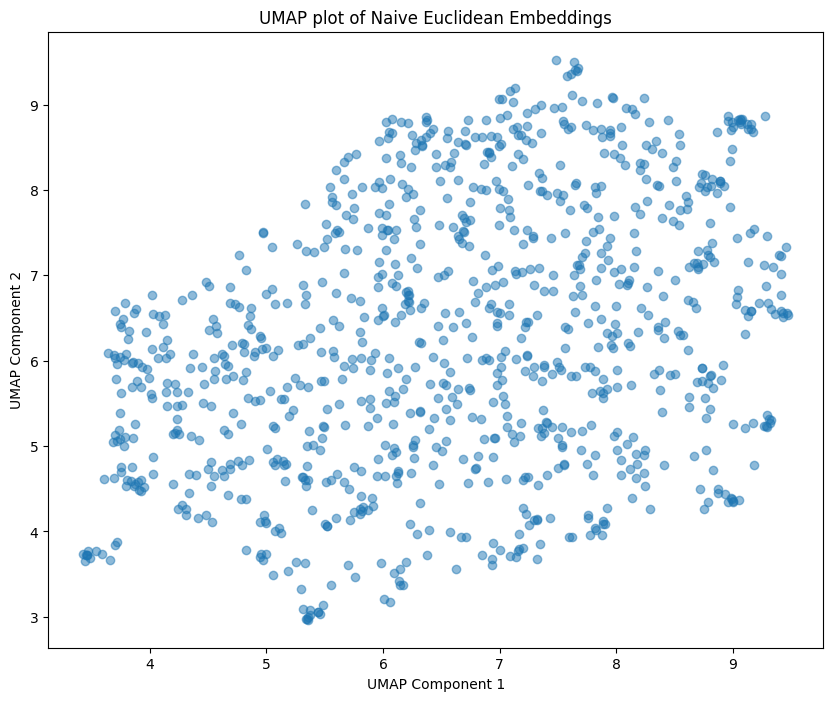

In [282]:
# Perform UMAP on the entity embeddings
umap_model = umap.UMAP(n_components=2, random_state=42) # plot
euclidean_embeddings_2d = umap_model.fit_transform(euclidean_sample_embeddings)

# UMAP plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(euclidean_embeddings_2d[:, 0], euclidean_embeddings_2d[:, 1], marker='o', alpha=0.5)
ax.set_title('UMAP plot of Naive Euclidean Embeddings')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
plt.show()

Here we see that the base model produces a more homogenous representation of the labels in the dataset. Since the model has not been trained on the dataset, or to do the task, this should correspond to the brute semantic similarities between the words.

## Part 2b): The Fine-Tuned Euclidean Language Model

Now we reproduce the fine-tuning of all-MiniLM-L12-v2 done by He et al. to assess a euclidean model who's embeddings should be a closer match to the structrue of the data.

### Fine-tuning commands

NB! this took about 2 hours

In [ ]:
fine_tune_path = cwd + "/scripts/training/sft"
config_file = fine_tune_path + "/config_sft.yaml"

!python {fine_tune_path}/training_sft.py --config_file {config_file}

### Loading and examining the model

In [283]:
checkpoint_path = fine_tune_path + "/experiments/SFT-all-MiniLM-L12-v2-WordNetNoun-MixedHop-RandomNegatives/checkpoint-8802"

ft_euclidean = AutoModel.from_pretrained(checkpoint_path)
ft_euclidean_tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

ft_euclidean.to('mps')

# Tokenize
np.random.seed(42) # reproduce
inputs = ft_euclidean_tokenizer([str for str in np.random.choice(entity_names, size=1000, replace=False)], padding=True, return_tensors="pt", truncation=True)

In [284]:
# get the embeddings 
with torch.no_grad():
    outputs = ft_euclidean(**inputs.to('mps'))

# Extract token embeddings
hidden_states = outputs.last_hidden_state 

# Mean pooling over token embeddings to get single rep
ft_euclid_embeds = hidden_states.mean(dim=1)

/opt/homebrew/Caskroom/miniconda/base/envs/hierarchytransformers/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/hierarchytransformers/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


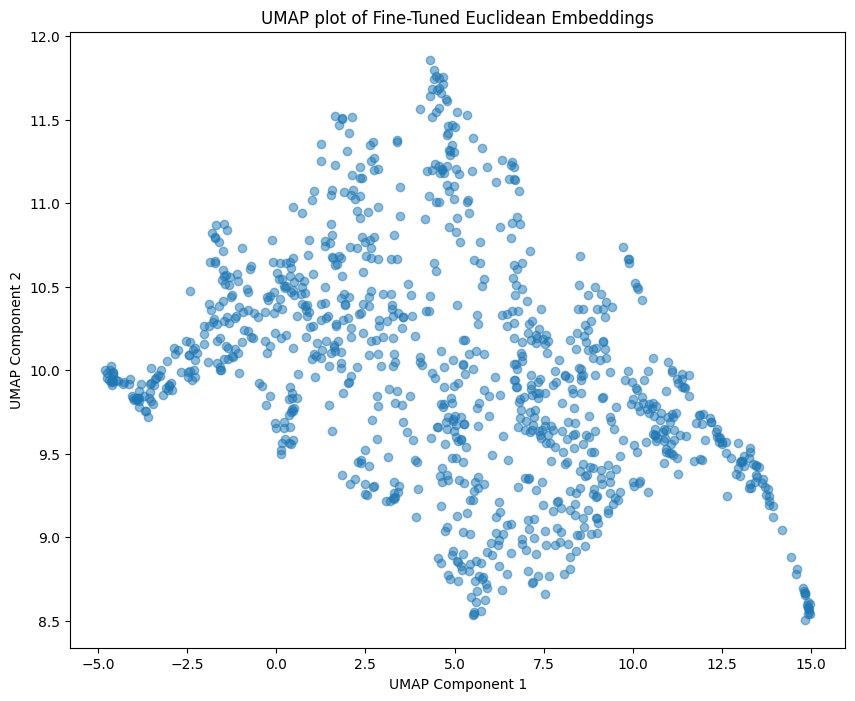

In [286]:
# plotting
umap_model_sentence = umap.UMAP(n_components=2, random_state=42)
ft_euclidean_2d_embeds = umap_model_sentence.fit_transform(ft_euclid_embeds.cpu().numpy())

# Plot the UMAP results in 2D
plt.figure(figsize=(10, 8))
plt.scatter(ft_euclidean_2d_embeds[:, 0], ft_euclidean_2d_embeds[:, 1], marker='o', alpha=0.5)
plt.title('UMAP plot of Fine-Tuned Euclidean Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

Here we see that the final embeddings are less homogenous than in the non-fine tuned model's case. In fact, we even start to see structures that look like the communities formed by the HiT. However, we also notice that this bundeling is extremely tight: it lacks a general sparcity of the HiT's representations.

These two results are likely reflected in the performance of these models on the dataset and task these samples come from. These results are shown in He et al Table 2, pg.7 (MixedHop Prediction Random Negatives). There, we see that the naive euclidean model has very low precision - it consistently missclassifies relationships, likely due to this homogenous representation. On the other hand, the fine-tuned euclidean model has relatively good precision - it is not tempted to make false positives. However, it's recall is very low, meaning that it misses many true positives, suggesting that the model is too conservative in its representations. Again, we can see this reflected in the structure of its embedding space: there are clusters that form, but they are not general enough to capture all of the relationships in the data. 

## Part 3: Comparing Hyperbolicity

In this final section, we compare the hyperbolicity of the 3 models. We consider the stimate of the gromov hyperbolicty of the embeddings, the average curvature, and the distribution of consine similarities between the models.

Firstly, we measure the curvature of the embeddings of the 3 models. 

In [307]:
def compute_average_curvature(embeddings):
    embeddings_tensor = torch.tensor(embeddings)
    norms = torch.norm(embeddings_tensor, dim=1)
    return norms.mean().item()

print("Average Curvature (Hyperbolic):", compute_average_curvature(hyperbolic_embeddings))
print("Average Curvature (Euclidean-Naive):", compute_average_curvature(euclidean_sample_embeddings))
print("Average Curvature (Euclidean-Fine-Tuned):",compute_average_curvature(ft_euclid_embeds.cpu().numpy()))
       

Average Curvature (Hyperbolic): 9.888410568237305
Average Curvature (Euclidean-Naive): 1.0
Average Curvature (Euclidean-Fine-Tuned): 4.887833595275879


Here we see that the the Hyperbolic embeddings have the highest average curvature, while the naive euclidean model has a standard euclidean curvature of 1.0. 

However, interestingly, the fine-tuned euclidean model has an average curvature higher than 1, which suggests that merely by doing the task, it has begun to learn to simulate certain hyperbolic tendencies, which is perhaps what allowed it to increase its performance on the task.

Now, we will look at the distributions between the cosine similarities of the different embeddings.



In [314]:
def compute_cosine_similarity(embeddings):
    embeddings_tensor = torch.tensor(embeddings)
    norms = F.normalize(embeddings_tensor, p=2, dim=1)
    similarity_matrix = torch.mm(norms, norms.T)
    return similarity_matrix.flatten().numpy()

# Compute cosine similarities
hyperbolic_cosine_sim = compute_cosine_similarity(hyperbolic_embeddings)
euclidean_cosine_sim= compute_cosine_similarity(euclidean_sample_embeddings)
euclidean_ft_cosine_sim = compute_cosine_similarity(ft_euclid_embeds.cpu().numpy())

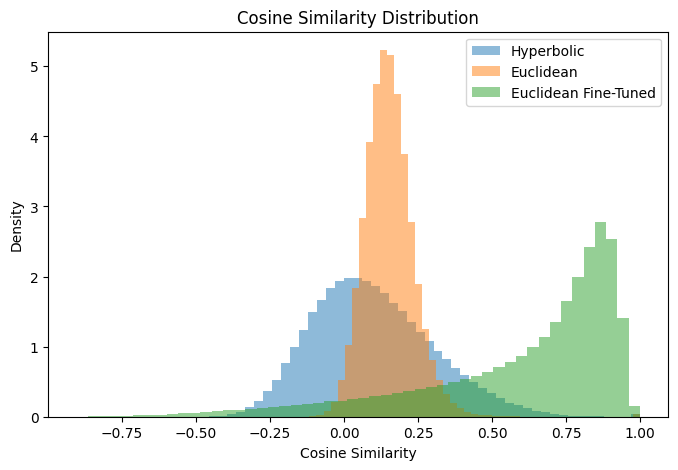

In [321]:
# Plot similarity distributions
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(hyperbolic_cosine_sim, bins=50, alpha=0.5, label="Hyperbolic", density=True)
ax.hist(euclidean_cosine_sim, bins=50, alpha=0.5, label="Euclidean", density=True)
ax.hist(euclidean_ft_cosine_sim, bins=50, alpha=0.5, label="Euclidean Fine-Tuned", density=True)
ax.set_xlabel("Cosine Similarity")
ax.set_ylabel("Density")
ax.set_title("Cosine Similarity Distribution")
ax.legend()
plt.show()

As we can see from the figure, the embeddings produced by the models have very consine similarity distributions. The Hyperbolic model has a wide distribution, which reflects its ability to encode both similarity and dissimilarity in the hierarchical data. On the other hand, the naive euclidean model does not really discriminate between entitites - it's cosine similarities are all clustered around small values. Finally, the fine-tuned euclidean model has a tendency to make extreme judgments, pushing many pairs close together.

## Citations

He, Y., Yuan, Z., Chen, J., & Horrocks, I. (2024). Language Models as Hierarchy Encoders (No. arXiv:2401.11374; Version 1). arXiv. https://doi.org/10.48550/arXiv.2401.11374

Reimers, N., & Gurevych, I. (2020). all-MiniLM-L12-v2 [Machine learning model]. Hugging Face. https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2
